In [2]:
from qiskit.circuit.library import XGate, YGate, ZGate, UnitaryGate
from qiskit.quantum_info import Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.circuit import QuantumCircuit, Instruction, QuantumRegister, ClassicalRegister
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer
import numpy as np
import random 

In [3]:
class GeneratePopulation:

    """
    Generates a population of pulse gate sequences using gates in `HIGH_FIDELITY_GATES`. 
    Single-qubit gates were chosen because of their high-fidelity. 

    The pulse sequences are generated via building arbitrary subsequences using 
    gates defined in `basis_gates`. These subsequences all tensor to the identity 
    matrix, up to an overall phase. 


    Methods
    -------

    def generate_individuals(self):
        generates one randomized sequence of pulse-gates using the provided class 
        parameterso build a single individual.
    
    def infant_product(self, infant):
        calculates the net unitary matrix from a list (`infant`) of matrices. 

    def is_identity(self, matrix): 
        checks whether matrix is quantum mechanically equivalent to an identity
        matrix (up to an overall global phase). 

    def population(self): 
        generates a pulse-gate population of randomized individuals of size 
        `num_individuals`. 

    Example
    -------
    class_ = GeneratePopulation(basis_gates=[XGate(), YGate(), ZGate()], 
                                num_individuals = 100, 
                                length_range = [4, 20],
                                max_gate_reps = 4, 
                                gate_names = ['X', 'Y', 'Z'],
                                verbose = True)

    class_.population()

    - Generates a population of 100 individuals. 
    - Each individual is made up of Pauli X, Y, Z gates. 
    - The gate depth (# gates) within an individual is between 4 and 20. 
    - A subsequence of an individual has at most 4 repetitions of the same gate. 
    
    """

    def __init__(self, basis_gates, num_individuals, max_gate_reps, 
                 approx_length = None, length_range = None, 
                 basis_names = None, verbose = True): 
        """
        Parameters
        ----------

        basis_gates: array-like
            stores the gates to use for generating randomized pulse gate sequences.

        num_individuals: int
            number of individuals in a population to generate.

        max_gate_reps: int 
            the maximum number of repetitions of a basis gate within a subsequence.

        OPTIONAL
        --------
        approx_length: int
            if defined, all individuals / pulse sequences in a population will have
            roughly the same gate depth = approx_length.

        length_range: [int_min, int_max] 
            if defind, all individuals / pulse sequences will be of randomized 
            depth between int_min and int_max.

        *** either approx_length or length_range must be defined ***

        basis_names : [string_1, string_2, ..., string_len(basis_states)]
            names of the operators in basis_states

        verbose: bool 
            to print out additional information when running

        """

        self.basis_gates = basis_gates
        self.num_individuals = num_individuals
        self.max_gate_reps = max_gate_reps
        self.approx_length = approx_length
        self.length_range = length_range
        self.basis_names =  basis_names
        self.verbose = verbose
        self.count = 0

    def generate_individual(self):

        """
        Generates randomized pulse-gate individual/sequence 

        Returns: 
        --------
        individual: list 
            list of matrices (numpy arrays) that make up the individual
        individual_name: 
            if self.basis_names provided, returns a simplified version of 
            the individual sequence using the names of each gate. 
            (i.e. ['X', 'Y', 'X', 'Y'] for XY4). Otherwise []. 

        """ 

        individual = []
        fixed_length = False

        if self.approx_length: 
            fixed_length = True
        elif self.length_range: 
            fixed_length = False
        else: 
            raise Exception('Either `self.approx_length` or `self.length_range` must be defined')

        if fixed_length: 
            while len(individual) < self.approx_length: 
                infant = [] 
                num_reps = random.choice(range(2, self.max_gate_reps, 2))
                basis_idxs = [random.randint(0, len(self.basis_gates) - 1) for j in range(num_reps)]

                for idx in basis_idxs: 
                    infant.append(self.basis_gates[idx])

                if self.is_identity(self.infant_product(infant)):
                    individual.extend(infant)
        else: 
            length = random.randint(self.length_range[0], self.length_range[1])
            while len(individual) < length: 
                infant = [] 
                num_reps = random.choice(range(2, self.max_gate_reps, 2))
                basis_idxs = [random.randint(0, len(self.basis_gates) - 1) for j in range(num_reps)]

                for idx in basis_idxs: 
                    infant.append(self.basis_gates[idx])

                if self.is_identity(self.infant_product(infant)):
                    individual.extend(infant)

        individual_name = []
        if self.basis_names: 
            for i in individual: 
                for j in range(len(self.basis_gates)): 
                    if np.allclose(i, self.basis_gates[j], atol = 1e-6): 
                      individual_name.append(self.basis_names[j])

            if self.verbose: 
                print(f"Individual {self.count+1}")
                print(f" {str(individual_name):>13}")
                print("")

        elif self.verbose: 
            print(f"Individual {self.count} generated.")

        return individual, individual_name

    def infant_product(self, infant): 

        # Calculates net unitary matrix from infant subsequence

        if not infant: 
            raise Exception('Infant was never born')

        return np.linalg.multi_dot(infant)

    def is_identity(self, matrix, tolerance = 1e-6): 

        # checks whether net unitary matrix from infant subsequence
        # is equivalent to identity matrix (up to overall global phase)

        identity_matrix = np.eye(matrix.shape[0])

        if matrix[0, 0] == 0: 
            return False

        normalized = matrix / matrix[0, 0]

        return np.allclose(normalized, identity_matrix, atol=tolerance)

    def population(self): 
        
        # Generates population of length `num_individuals`
        # Each individual pseudo-randomized based on class parameters.

        population  = []

        for i in range(self.num_individuals): 
            individual, _ = self.generate_individual()
            individual = self.individual_to_dd(individual)

            if individual not in population: 
                population.append(individual)

            self.count += 1

        if self.verbose:
            print("")
            print("Population generated")
            print("")

        return population

    def individual_to_dd(self, individual):
        dd_individual = []

        for gate_idx in range(len(individual)): 
            for basis_gate_idx in range(len(self.basis_gates)): 
                if np.allclose(Operator(individual[gate_idx]), self.basis_gates[basis_gate_idx], atol = 1e-6):
                    unitary_gate = UnitaryGate(self.basis_gates[basis_gate_idx])
                    unitary_gate.name = self.basis_names[basis_gate_idx]
                    dd_individual.append(unitary_gate)
        return dd_individual






class_ = GeneratePopulation(basis_gates=[XGate(), YGate(), ZGate()], 
                            num_individuals = 8, 
                            length_range = [4, 6],
                            max_gate_reps = 6, 
                            basis_names = ['x', 'y', 'z'],
                            verbose = True)

population = class_.population()

Individual 1
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x']

Individual 2
 ['z', 'z', 'z', 'z']

Individual 3
 ['z', 'z', 'z', 'z', 'z', 'z']

Individual 4
 ['x', 'x', 'x', 'x', 'y', 'y']

Individual 5
 ['z', 'x', 'z', 'x']

Individual 6
 ['x', 'x', 'y', 'y']

Individual 7
 ['x', 'x', 'y', 'x', 'x', 'y']

Individual 8
 ['y', 'z', 'y', 'z', 'y', 'y']


Population generated



In [4]:
def draw(circuit): 
    from qiskit import transpile

    scheduled = transpile(
        circuit, 
        optimization_level = 0, 
        instruction_durations = InstructionDurations(), 
        scheduling_method = 'alap'
    )

    return display(timeline_drawer(scheduled))

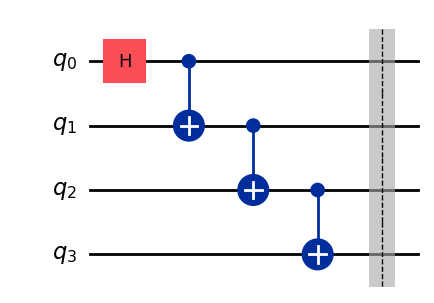

In [5]:
qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.barrier()

qc.draw('mpl')

In [6]:
def generate_gate_timing(circuit, verbose = False):
    gate_timings = []

    for instruction in circuit.data:
        inst = instruction.operation
        qubits = [circuit.find_bit(qubit).index for qubit in instruction.qubits]  
        
        duration = instruction.operation.duration if hasattr(inst, 'duration') else None

        gate_timings.append({
            'gate': inst.name,
            'qubits': qubits,
            'duration': duration,
        })

    if verbose: 
        for timing in gate_timings:
            print('{:<4} | {:<6} | {}'.format('Gate', 'Qubit', 'Duration'))
            print('{:<4} | {:<6} | {}'.format(timing['gate'],
                                              str(timing['qubits']),
                                              timing['duration']))
        
    return gate_timings

def gate_timing_to_duration(gate_timings): 
    durations_list = []
    for gate in gate_timings: 
        durations_list.append((gate['gate'], gate['qubits'], 100))

    return durations_list

durations_list = gate_timing_to_duration(generate_gate_timing(qc, True))

Gate | Qubit  | Duration
h    | [0]    | None
Gate | Qubit  | Duration
cx   | [0, 1] | None
Gate | Qubit  | Duration
cx   | [1, 2] | None
Gate | Qubit  | Duration
cx   | [2, 3] | None
Gate | Qubit  | Duration
barrier | [0, 1, 2, 3] | None


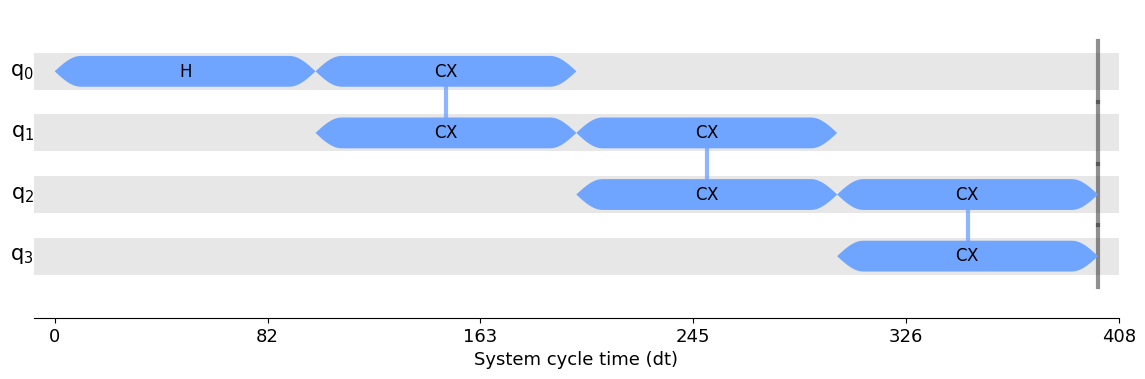

In [7]:
individual = population[0]

for unitary_gate in individual: 
    if ((unitary_gate.name, None, 1000) not in durations_list):
        durations_list.append((unitary_gate.name, None, 1000))

durations = InstructionDurations(
    durations_list
)

pm = PassManager(
    [
        ALAPSchedule(durations), 
        DynamicalDecoupling(durations, individual)
    ]
)

qc_dd = pm.run(qc)
draw(qc_dd)

In [8]:
def calculate_intervals_with_delays(gate_timings, qubit):
    timings = [t for t in gate_timings if qubit in t['qubits']]
    intervals = []

    i = 0
    while i < len(timings) - 1:
        curr_gate = timings[i]
        next_gate = timings[i + 1]

        if next_gate['gate'] == 'delay' and qubit in next_gate['qubits']:
            delay_duration = next_gate['duration']

            if i + 2 < len(timings):
                next_gate_after_delay = timings[i + 2]
                intervals.append({
                    'between': (curr_gate['gate'], next_gate_after_delay['gate']),
                    'interval': delay_duration
                })
                i += 2  
            else:
                break  
        else:
            i += 1

    return intervals

intervals = []
for qubit_idx in range(qc_dd.num_qubits): 
    qubit_intervals = calculate_intervals_with_delays(generate_gate_timing(qc_dd), qubit_idx)
    intervals.append(qubit_intervals)
    print(f"\nTime intervals between gates for qubit {qubit_idx}:")
    print(qubit_intervals)


Time intervals between gates for qubit 0:
[{'between': ('cx', 'barrier'), 'interval': 200}]

Time intervals between gates for qubit 1:
[{'between': ('cx', 'barrier'), 'interval': 100}]

Time intervals between gates for qubit 2:
[]

Time intervals between gates for qubit 3:
[]


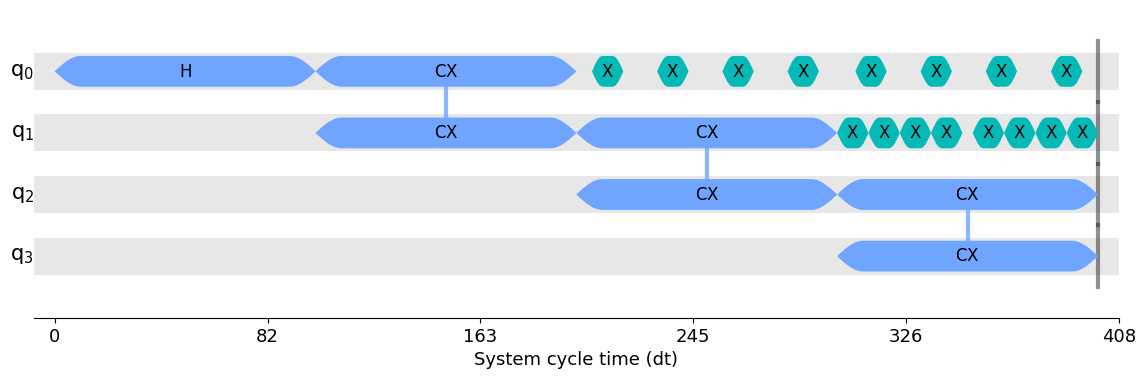

In [9]:
minimum = [] 
for i in range(len(intervals)): 
    if len(intervals[i]) > 0: 
        if len(intervals[i]) > 1: 
            minimum.append([intervals[i][j]['interval'] for j in range(len(intervals[i]))])
        else: 
            minimum.append([intervals[i][0]['interval']])
    
minimum = min(minimum)

individual = population[0]
padding = int(minimum[0] / len(individual) - random.randint(0, 10))


base_durations = gate_timing_to_duration(generate_gate_timing(qc))

for unitary_gate in individual: 
    if ((unitary_gate.name, None, padding) not in base_durations):
        base_durations.append((unitary_gate.name, None, padding))

base_durations.extend([('measure', None, 1000)])

base_durations = InstructionDurations(base_durations)

pm = PassManager(
    [
        ALAPSchedule(base_durations), 
        DynamicalDecoupling(base_durations, individual)
    ]
)

dd_qc = pm.run(qc)

draw(dd_qc)

In [10]:
dd_qc.data = [
    instruction for instruction in dd_qc.data
    if instruction[0].name != 'barrier'
]

dd_qc.data = [
    instruction for instruction in dd_qc.data
    if instruction[0].name != 'barrier'
]

dd_qc.data = [
    instruction for instruction in dd_qc.data
    if instruction[0].name != 'id'
]

dd_qc.compose(qc.inverse(), inplace=False)
dd_qc.measure_all()

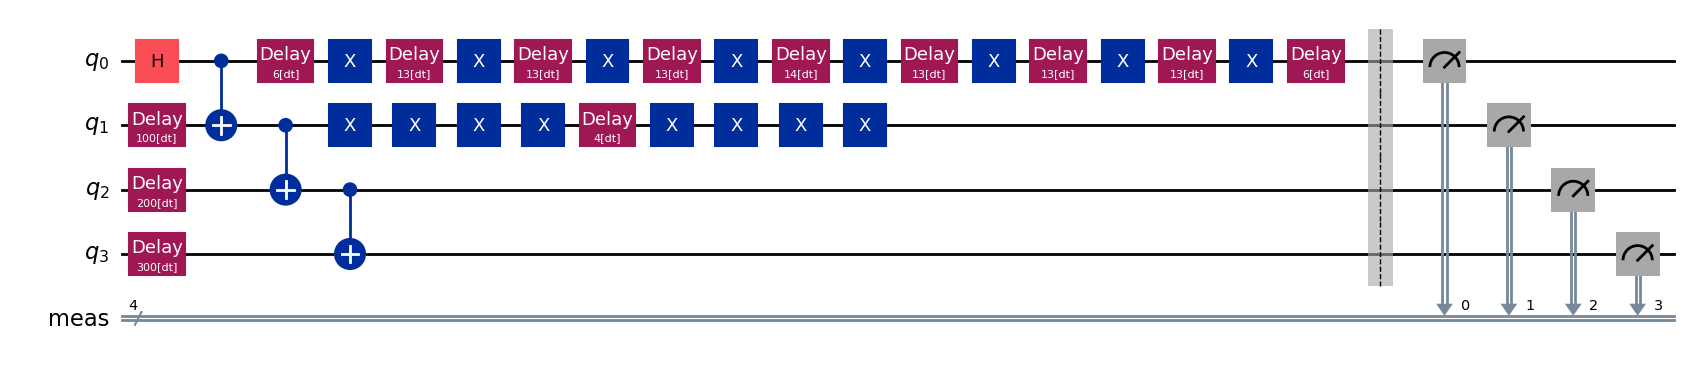

In [11]:
dd_qc.draw('mpl')

In [12]:
qcf = QuantumCircuit(4)

for gate_name, qargs, cargs in dd_qc.data:
    qubits = [dd_qc.find_bit(qarg)[0] for qarg in qargs]
    if gate_name.name != 'barrier' and gate_name.name != 'measure': 
        if len(qubits) >= 2 and len(qubits) < 3: 
            getattr(qcf, gate_name.name)(*qubits)
        elif len(qubits) < 2: 
            getattr(qcf, gate_name.name)(qubits[0])

    
    getattr(qcf, gate_name.name)
qcf.compose(qc.inverse(), inplace=True)
qcf.measure_all()

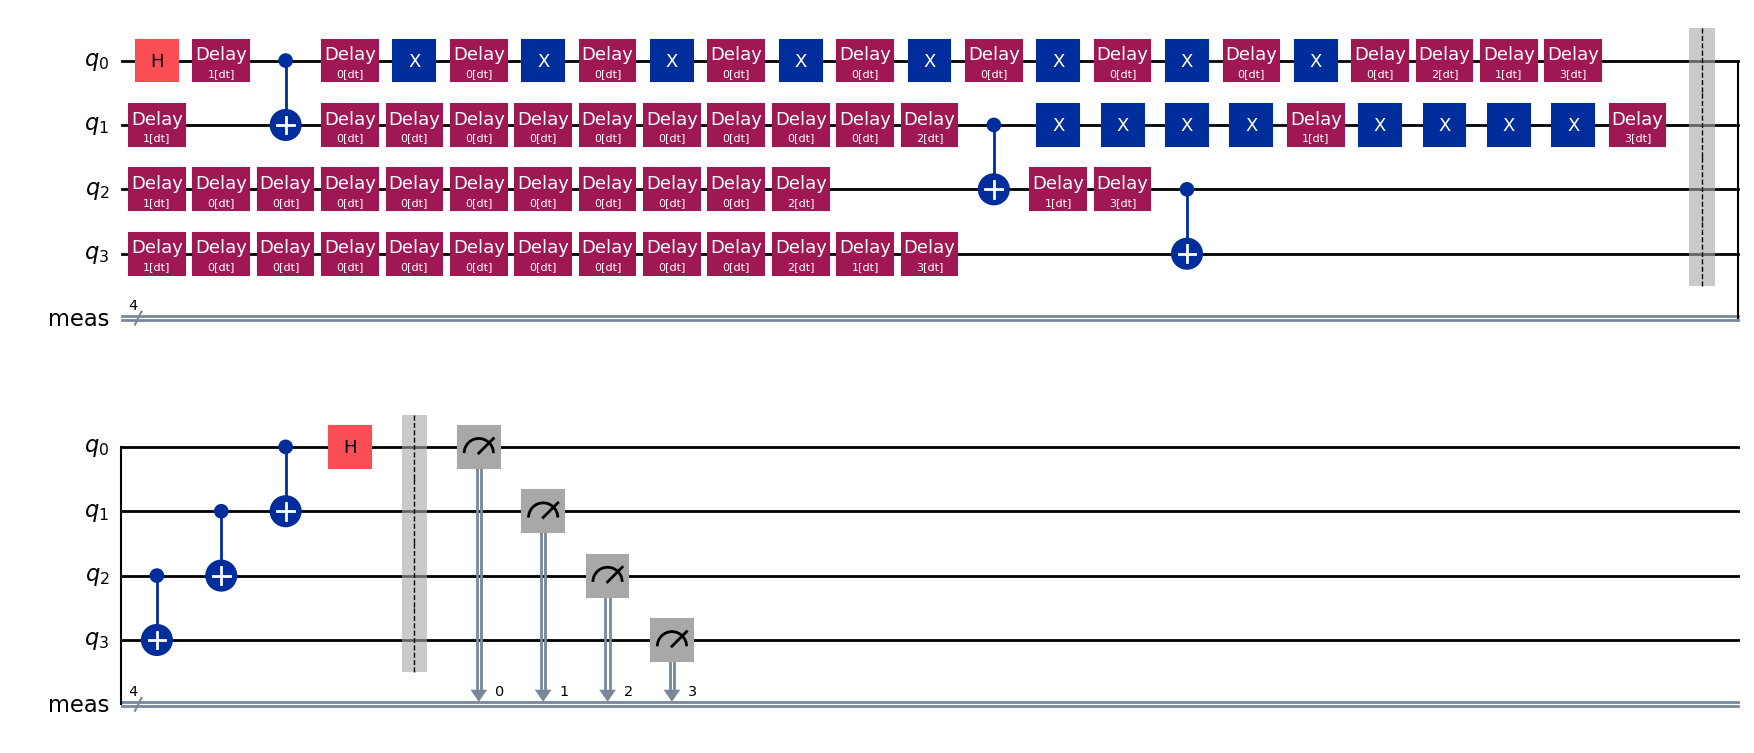

In [13]:
qcf.draw('mpl')

## FakeOsaka Backend

0.922


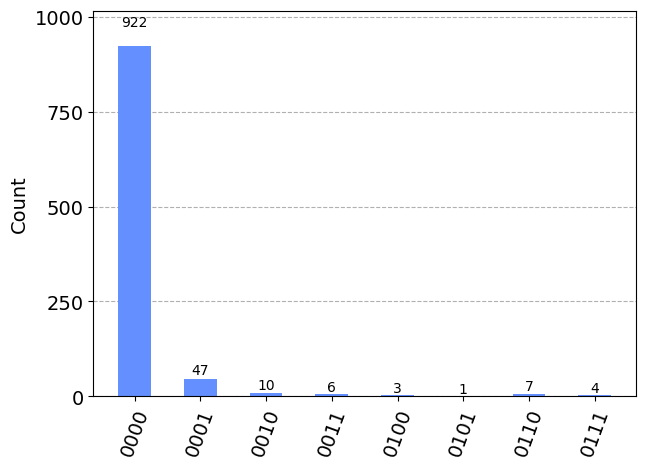

In [14]:
from qiskit_aer import QasmSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit_aer import AerSimulator, Aer

base_durations = gate_timing_to_duration(generate_gate_timing(qc))

for unitary_gate in individual: 
    if ((unitary_gate.name, None, padding) not in base_durations):
        base_durations.append((unitary_gate.name, None, padding))

base_durations.extend([('measure', None, 1000)])

t1 = 10e3  
t2 = 5e3 
thermal_error = thermal_relaxation_error(t1, t2, 100)

noise_model = NoiseModel()
depol_error = depolarizing_error(0.1, 1)
noise_model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(thermal_error, ['id', 'delay'])

pm = PassManager(ALAPSchedule(durations = InstructionDurations(base_durations)))
scheduled_qc = pm.run(qcf)

backend = QasmSimulator()
job = backend.run(transpile(scheduled_qc, backend, scheduling_method='alap'), noise_model=noise_model, shots = 1000).result()
counts = job.get_counts()
prob_zero = counts['0000'] / 1000

print(prob_zero)
plot_histogram(counts)


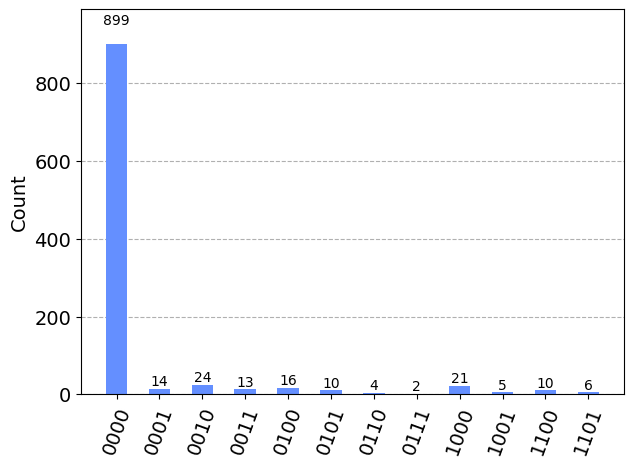

In [15]:
base_durations = gate_timing_to_duration(generate_gate_timing(qc))

for unitary_gate in individual: 
    if ((unitary_gate.name, None, padding) not in base_durations):
        base_durations.append((unitary_gate.name, None, padding))

base_durations.extend([('measure', None, 1000)])

pm = PassManager(ALAPSchedule(durations = InstructionDurations(base_durations)))
scheduled_qc = pm.run(qcf)

backend = FakeAthens() 

job = backend.run(transpile(scheduled_qc, backend, scheduling_method='alap'), shots = 1024).result()
counts = job.get_counts()

plot_histogram(counts)

In [6]:
probabilities = {'backend': [0], 
                'mitigated_success': [0], 
                'unmitigated_success': [0], 
                'sequence': [0]}

In [35]:
import pandas as pd

probabilities = pd.DataFrame(probabilities)

rowIndex = probabilities.columns.get_loc('sequence')
probabilities.at[len(probabilities) - 1, 'backend'] = 'Jakarta'